In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import math

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [14]:
num_hiddens = 256
# refer https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
rnn_layer = nn.RNN(len(vocab), num_hiddens)
init_hidden_state = torch.zeros((1, batch_size, num_hiddens))
init_hidden_state.shape

torch.Size([1, 32, 256])

In [15]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, init_hidden_state)
# Y contains the output features (h_t) from the last layer of the RNN, for each t. 
# it refers to the hidden state at each time step, and they can be used as the input to the 
# subsequent output layer. Y is not the prediction at each time step
# state_new is the final hidden state of each element in the batch
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [16]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        # The linear layer is for making predictions 
        if not self.rnn.bidirectional:
            self.num_directions = 1
            # input to linear output layer is of shape num_steps, batch_size, num_hiddens
            # and output is of shape num_steps, batch_size, vocab_size
            # Wya is of shape (vocab_size, num_hiddens), a_out is of shape (num_hiddens, 1)
            # yt_pred = np.dot(Wya, a_out) + b is of shape (vocab_size, 1)
            # replace 1 with m (batch_size) and add num_steps as the first dimension to have
            # vectorized form of the output
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        # convert input X (which is an integer index) to one hot encoded vector form
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The the output Y of fully connected rnn layer has the shape of 
        # (`num_steps` * `batch_size`, `num_hiddens`). This Y is then fed as input to the 
        # output linear layer which produces the prediction in the output shape of 
        # (`num_steps` * `batch_size`, `vocab_size`).
        # The input to linear output layer is of shape ((num_steps * batch_size), num_hiddens)
        # Y.shape[-1] = num_hiddens
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        # Output from linear layer is of shape ((num_steps * batch_size), vocab_size)
        return output, state

    def begin_state(self, device, batch_size=1):
        """ Initialize the hidden state i.e. initialize all the neurons in all the hidden layers 
        to zero"""
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [17]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

Specifically, when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch. Since the  ith  subsequence example in the next minibatch is adjacent to the current  ith  subsequence example, the hidden state at the end of the current minibatch will be used to initialize the hidden state at the beginning of the next minibatch. In this way, historical information of the sequence stored in the hidden state might flow over adjacent subsequences within an epoch. However, the computation of the hidden state at any point depends on all the previous minibatches in the same epoch, which complicates the gradient computation. To reduce computational cost, we detach the gradient before processing any minibatch so that the gradient computation of the hidden state is always limited to the time steps in one minibatch.

In [18]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        # forward step 
        y_hat, state = net(X, state)
        # loss calculation
        l = loss(y_hat, y.long()).mean()
        # backward step
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [22]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [20]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.3, 70000.6 tokens/sec on cuda:0
[3]
time traveller of croves nown baty of the promincial mayorit is 
[3]
traveller comenot blightire it rightss coomentyere we have 


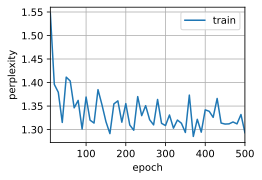

In [31]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [33]:
predict_ch8('for is it ', 100, net, vocab, d2l.try_gpu())

[16]


'for is it the formen ssid thacfolly bout overy which we call the three planes of space and a fourth timethere '